In [1]:
import dask
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from datetime import timedelta, datetime

from eofs.xarray import Eof

import warnings
warnings.filterwarnings("ignore")

### The Palmer Drought Severity Index (PDSI) is an index used to quantify long-term drought ranging on a scale from spans from -10 (dry) to +10 (wet). It uses temperature, precipitation, soil moisture, and evapotranpiration data

This project uses Empirical Orthogonal Functions (EOF) to identify patterns of variability and analyses the patterns responsible for the most variance of the data.

In [2]:
# File Path URL for the historical PDSI dataset
file_url_path = "https://tds.gdex.ucar.edu/thredds/dodsC/files/g/d299000/pdsisc.monthly.maps.1850-2018.fawc-1.r2.5x2.5.ipe-2.nc"

In [3]:
def linear_detrend(da):
    # Remove a linear trend each grid point.
    trend = da.polyfit("time", 1)
    fit = xr.polyval(da["time"], trend.polyfit_coefficients)
    return da - fit

In [4]:
def monthly_anom_and_z(
    detr: xr.DataArray | xr.Dataset,
    time_dim: str = "time",
    base_period: tuple[str, str] | None = None,
    ddof: int = 1,
    eps: float = 1e-6,
):
    """
    From linearly-detrended data, remove monthly climatology and compute monthly z-scores.
    Returns (anom, z). Works for Dataset or DataArray.
    """
    clim_src = (
        detr if base_period is None else detr.sel({time_dim: slice(*base_period)})
    )
    key = f"{time_dim}.month"

    clim_mean = clim_src.groupby(key).mean(time_dim, skipna=True)
    anom = detr.groupby(key) - clim_mean

    clim_std = clim_src.groupby(key).std(time_dim, skipna=True, ddof=ddof)
    safe_std = xr.where(clim_std > eps, clim_std, np.nan)
    z = anom.groupby(key) / safe_std
    return anom, z

In [5]:
# Open netCDF file from UCAR url
ds = xr.open_dataset(file_url_path, decode_times=False)

# Convert fractional year to timestamp
dates = []
for fy in ds.time.values:
    year = int(fy)
    fraction = fy - year

    # Calculate days in the year, considering leap years
    is_leap = (year % 4 == 0 and year % 100 != 0) or (year % 400 == 0)
    days_in_year = 366 if is_leap else 365

    days_offset = int(fraction * days_in_year)

    # Create a datetime object for January 1st of the year
    start_of_year = datetime(year, 1, 1)

    # Add the calculated days offset
    target_date = start_of_year + timedelta(days=days_offset)
    dates.append(target_date)

ds = ds.assign_coords(time=("time", dates))
ds = ds.sel(time=slice("1950-01-01", "2018-12-16"))

ds.time

<xarray.DataArray 'time' (time: 828)> Size: 7kB
array(['1950-01-16T00:00:00.000000000', '1950-02-15T00:00:00.000000000',
       '1950-03-18T00:00:00.000000000', ..., '2018-10-16T00:00:00.000000000',
       '2018-11-16T00:00:00.000000000', '2018-12-16T00:00:00.000000000'],
      shape=(828,), dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 7kB 1950-01-16 1950-02-15 ... 2018-12-16

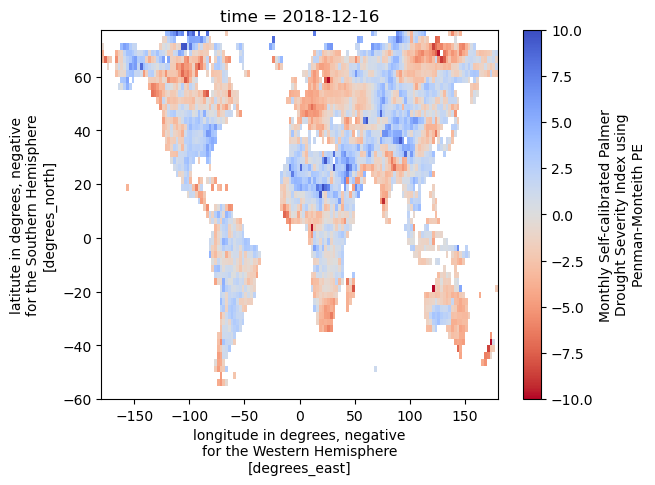

In [6]:
# Test plot of most recent data
ds["sc_PDSI_pm"][-1, :, :].plot(cmap="coolwarm_r")
plt.show()

This figure shows PDSI values for the month of December 2018. The red areas indicating areas of dryness and the blue areas indicating wet areas. As seen in the figure during that month there was severe drought in parts of Northeastern Asia, Eastern Europe, and Northern North America.

In [7]:
# Compute anomalies by detrending and deseasonalizing data
detr = linear_detrend(ds["sc_PDSI_pm"])
anom, z = monthly_anom_and_z(detr, time_dim="time")
z = z.drop_vars(["month"])
z

<xarray.DataArray (time: 828, lat: 55, lon: 144)> Size: 52MB
array([[[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [ 0.68759993,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
...
        [ 0.14766134,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [ 0.41177181,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]]], shape=(828, 55, 144))
Coordinates:
  * time     (time) datetime64[ns] 7kB 1950-01-16 1950-02-15 ... 2018-12-16
  * lat      (lat) float32 220B -58.75 -56.25 -53.75 ... 71.25 73.75 76.25
  * lon      (lon) float32 576B -178.8 -176.2 -173.8 ... 173.8 176.2 178.8

To account for linear trends the data is detrended by fitting a linear polynomial, calculating the trend line values, and subtracting from the original data. Then to account for the seasonal cycle monthly anomalies and monthly z scores are computed.

In [8]:
# Take latiutude weights and create EOF solver
coslat = np.cos(np.deg2rad(z.coords["lat"].values))
wgts = np.sqrt(coslat)[..., np.newaxis]
solver = Eof(z, weights=wgts)

In [9]:
# Find the first 5 EOFs
nEOFS = 5
eofs = solver.eofsAsCorrelation(neofs=nEOFS)

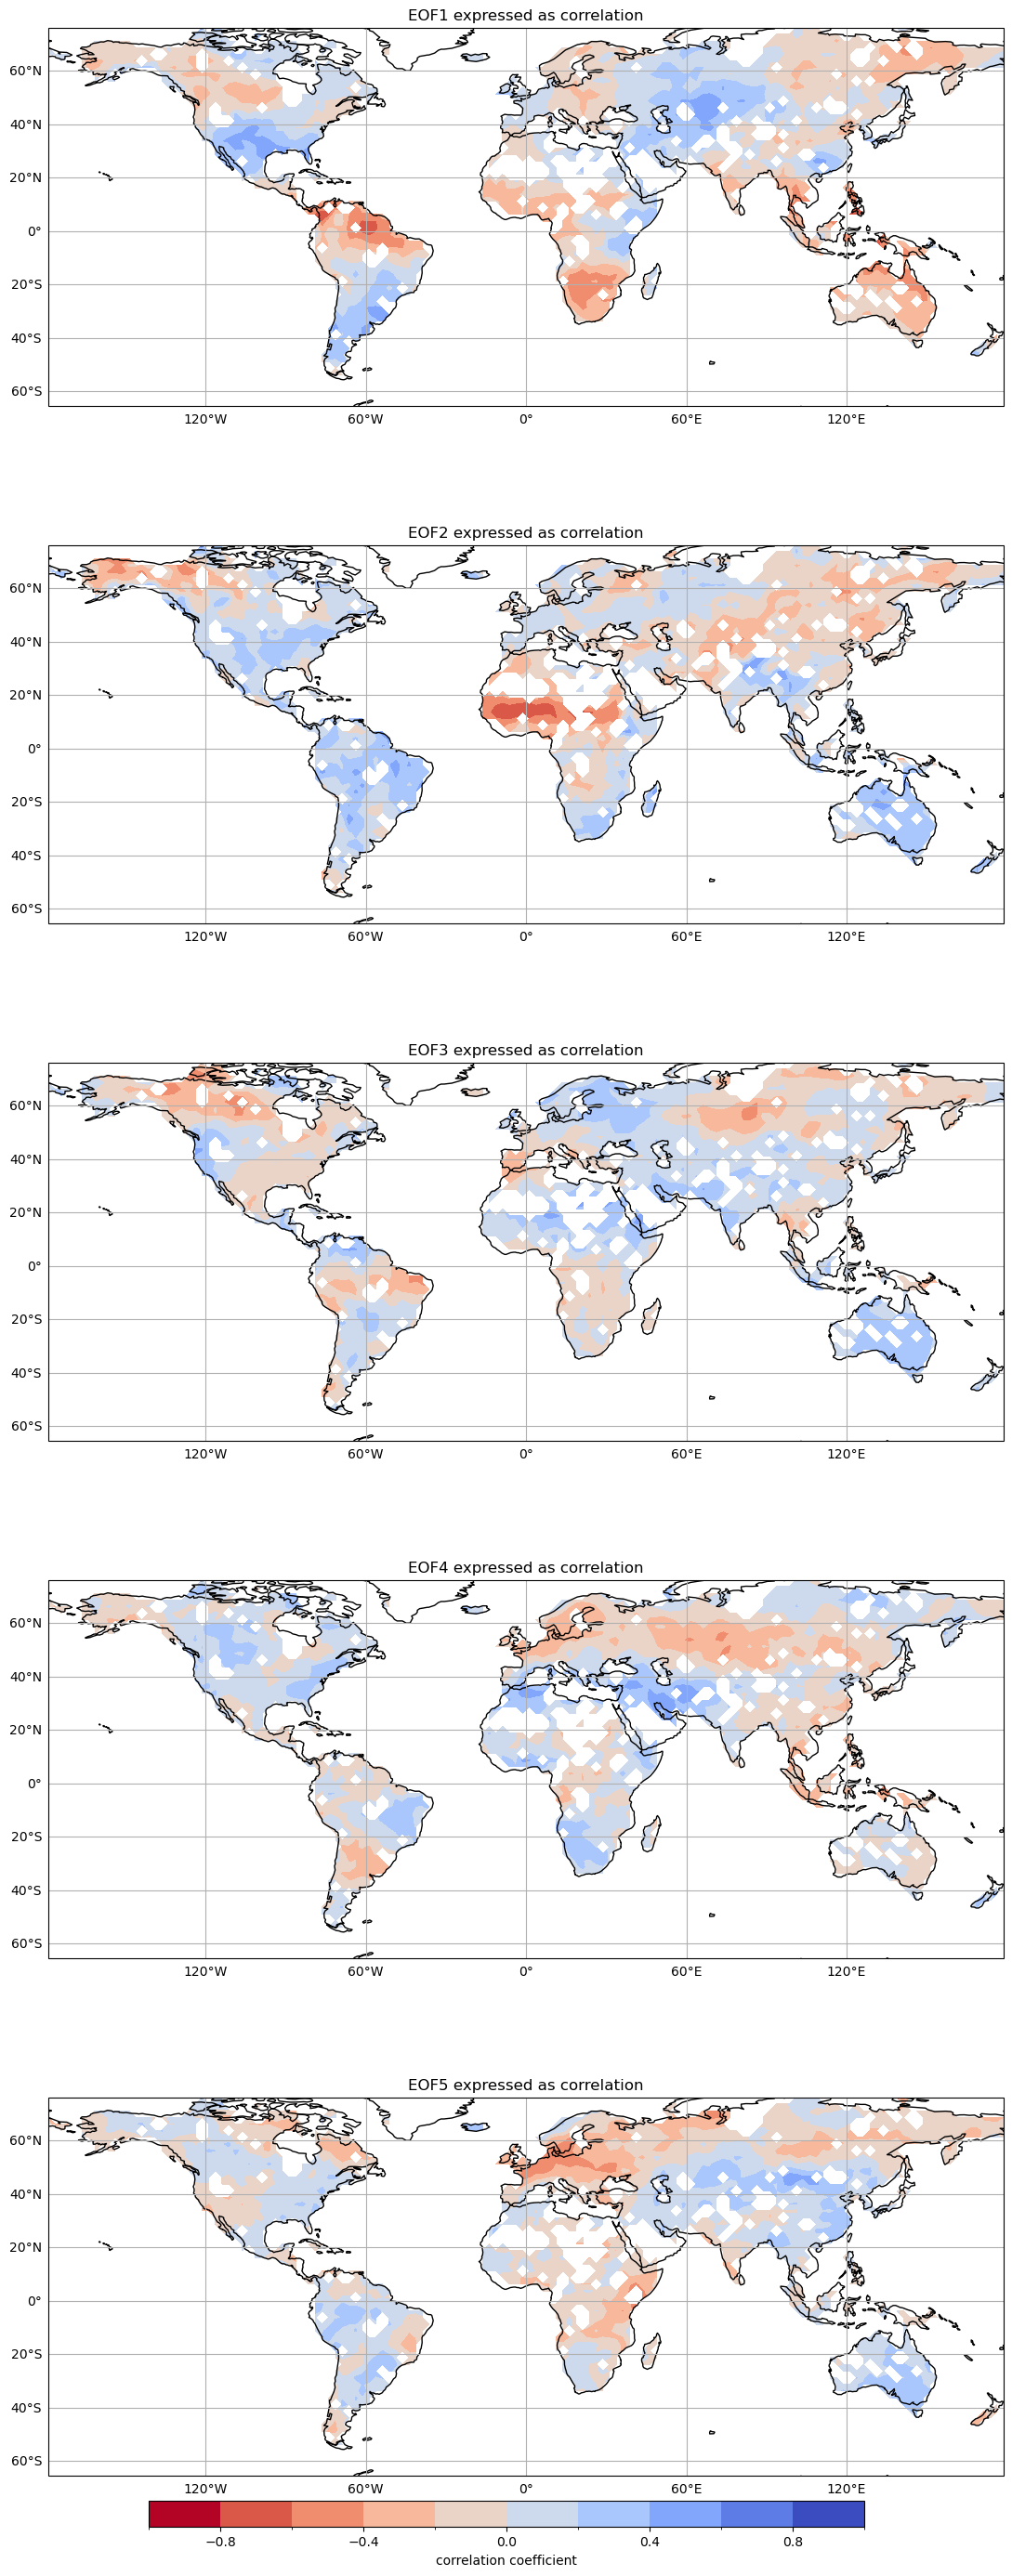

In [10]:
# Plot the first 5 EOFs expressed as correlation
clevs = np.linspace(-1, 1, 11)

fig, axes = plt.subplots(
    nEOFS,
    figsize=(11, 28),
    subplot_kw=dict(projection=ccrs.PlateCarree()),
)

for i in range(nEOFS):
    fill = eofs[i].plot.contourf(
        ax=axes[i],
        cmap="coolwarm_r",
        levels=clevs,
        add_colorbar=False,
        transform=ccrs.PlateCarree(),
    )
    gl = axes[i].gridlines(draw_labels=True)
    gl.top_labels = False
    gl.right_labels = False
    axes[i].coastlines()
    axes[i].set_title(f"EOF{i+1} expressed as correlation")

cbar_ax = fig.add_axes([0.15, 0.01, 0.7, 0.01])  # left, bottom height ,length, width
cb = fig.colorbar(fill, orientation="horizontal", cax=cbar_ax)
cb.set_label("correlation coefficient")
plt.tight_layout()
plt.show()

The leading EOF shows drought in areas of northern South America, southern Africa, east Asia, and Australia and wetness in the southern US and Central Asia. This variability may be connected to climate variability such as ENSO, which we will see further down.

In [11]:
# Find fractional variance
varFrac = solver.varianceFraction()

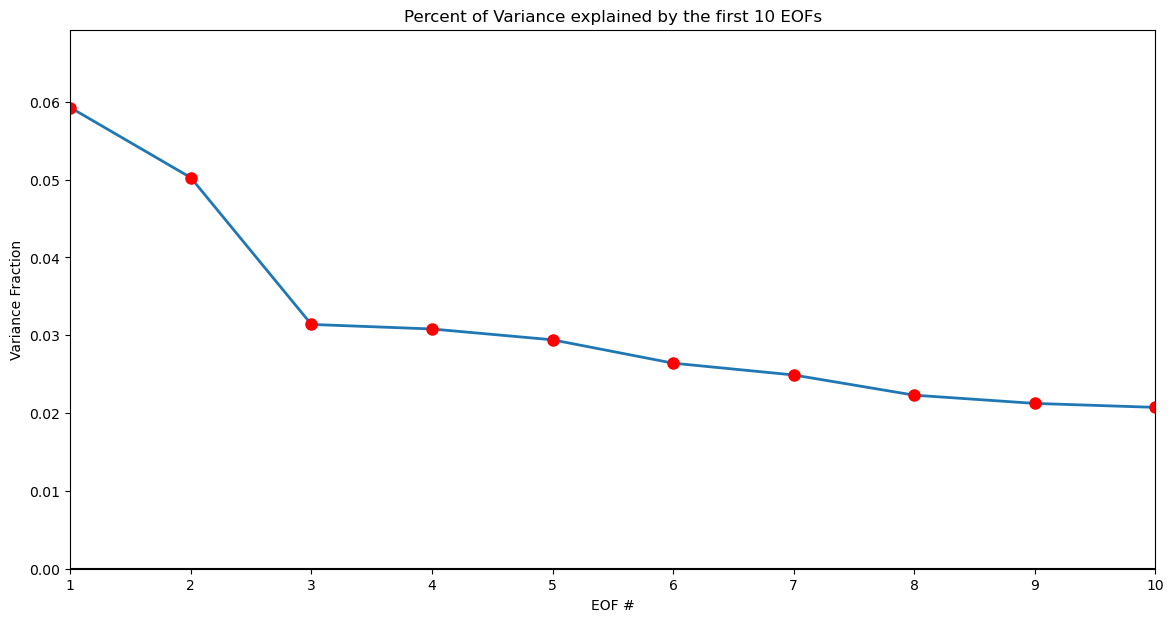

In [12]:
# Plot fractional variance of the first 10 EOFs
fig, ax = plt.subplots(figsize=(14, 7))
eof_num = range(1, 11)
ax.plot(eof_num, varFrac[0:10], linewidth=2)
ax.plot(eof_num, varFrac[0:10], linestyle="None", marker="o", color="r", markersize=8)
ax.axhline(0, color="k")
ax.set_xticks(eof_num)
ax.set_title("Percent of Variance explained by the first 10 EOFs")
ax.set_xlabel("EOF #")
ax.set_ylabel("Variance Fraction")
ax.set_xlim(1, 10)
ax.set_ylim(np.min(varFrac), np.max(varFrac) + 0.01)
plt.show()

Our first EOF accounts for about 6% of the variance while the second accounts for about 5% and the rest between 2-3%.

Lets now analyze the time series of our leading Principal Components

In [13]:
# Find first 2 leading Principal Component time series
pc = solver.pcs(npcs=2, pcscaling=1)

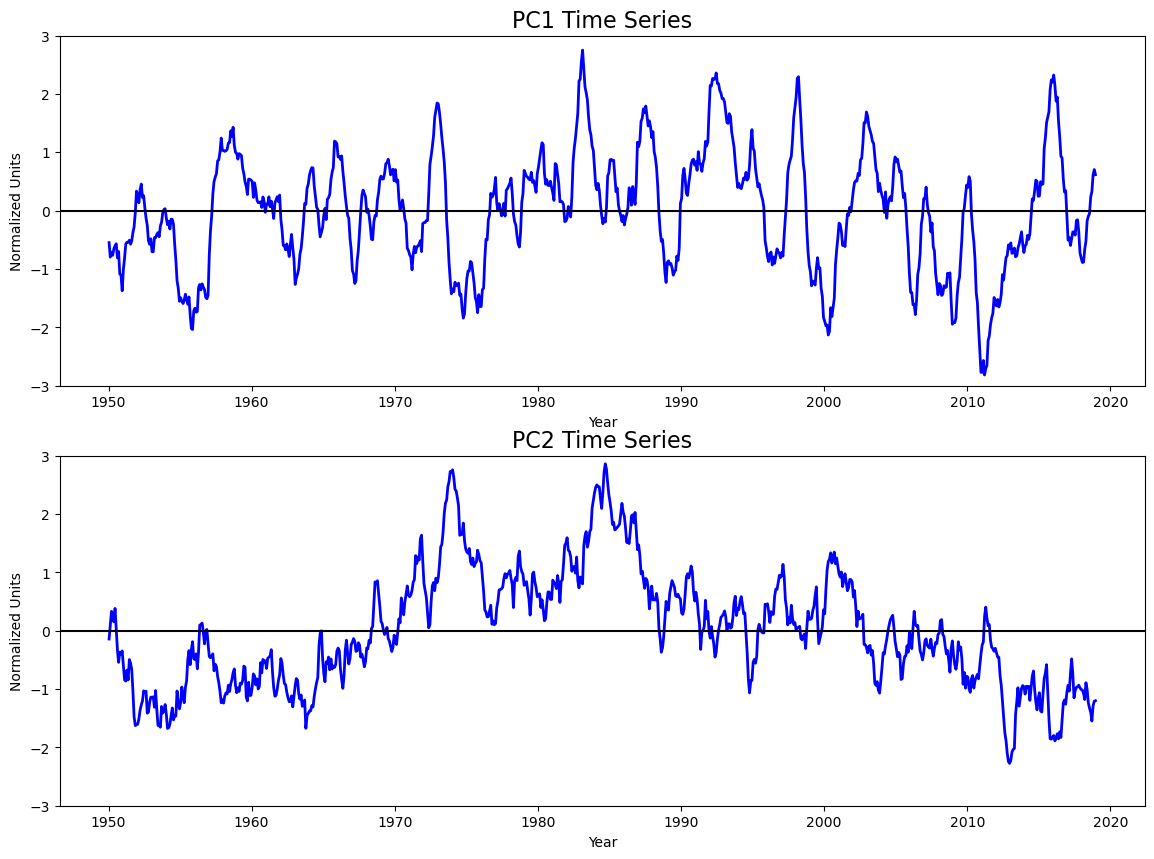

In [14]:
# Plot the leading PC time series.
fig, axes = plt.subplots(2, figsize=(14, 10))
pc[:, 0].plot(ax=axes[0], color="b", linewidth=2)
axes[0].axhline(0, color="k")
axes[0].set_ylim(-3, 3)
axes[0].set_xlabel("Year")
axes[0].set_ylabel("Normalized Units")
axes[0].set_title("PC1 Time Series", fontsize=16)

pc[:, 1].plot(ax=axes[1], color="b", linewidth=2)
axes[1].axhline(0, color="k")
axes[1].set_ylim(-3, 3)
axes[1].set_xlabel("Year")
axes[1].set_ylabel("Normalized Units")
axes[1].set_title("PC2 Time Series", fontsize=16)
plt.show()

Now lets take a look at the ENSO index during the same time frame as our leading Principal Component and compare.

In [15]:
# Read in Oceanic Nino Index data from NOAA PSL
enso = pd.read_csv(
    "https://psl.noaa.gov/data/correlation/oni.csv",
    header=0,
    names=["Date", "ONI"],
    parse_dates=["Date"],
    engine="python",
)
enso = enso[(enso["Date"] >= "1950-01-01") & (enso["Date"] <= "2018-12-01")]
enso

,Date,ONI
0,1950-01-01,-1.53
1,1950-02-01,-1.34
2,1950-03-01,-1.16
3,1950-04-01,-1.18
4,1950-05-01,-1.07
...,...,...
823,2018-08-01,0.23
824,2018-09-01,0.49
825,2018-10-01,0.76
826,2018-11-01,0.90


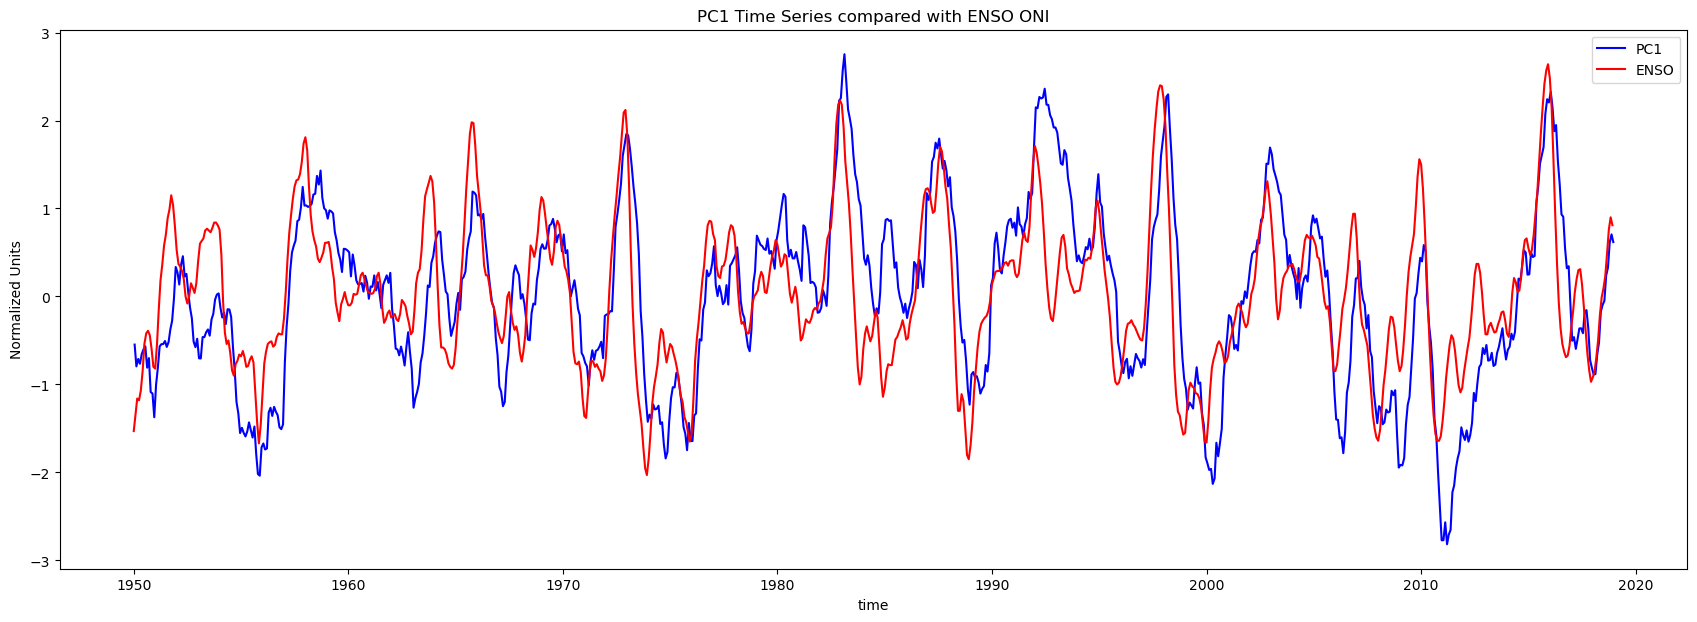

In [16]:
# Plot ENSO index and leading PC
fig, ax = plt.subplots(figsize=(21, 7))
pc[:, 0].plot(ax=ax, color="b", label="PC1")
ax.plot(enso["Date"], enso["ONI"], color="r", label="ENSO")
ax.set_title("PC1 Time Series compared with ENSO ONI")
ax.set_ylabel("Normalized Units")
ax.legend()
plt.show()

In [17]:
# Find pearson correlation between the leading PC and ENSO index
pc1 = pd.Series(pc[:, 0], index=enso.index, name="PC1")

corr = pc1.corr(enso["ONI"])
print(corr)

0.7230211615825665


### As shown in the plot and Pearson Correlation coefficient (0.723) our leading PC and ENSO index have a strong positive correlation!